## load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
df = pd.read_csv("./data/crawled/may.tsv", quoting=3, sep="\t")

In [3]:
df = df.drop_duplicates(subset="text")

In [4]:
df = df[df["text"].str.len() > 20]

In [5]:
df.describe(include="all")

,tweet_id,user_id,publish_date,text,user_gender,location
count,6.654920e+05,6.654920e+05,665492,665492,665492,665486
unique,NaN,NaN,619741,665492,3,31430
top,NaN,NaN,2017-06-09 11:57:58,I've said we're in danger of becoming #NorthKo...,UNKNOWN,None
freq,NaN,NaN,9,1,298017,360497
mean,8.509458e+17,1.247626e+17,NaN,NaN,NaN,NaN
std,2.320309e+16,2.881098e+17,NaN,NaN,NaN,NaN
min,2.477579e+17,3.365000e+03,NaN,NaN,NaN,NaN
25%,8.259932e+17,1.454136e+08,NaN,NaN,NaN,NaN
50%,8.569229e+17,5.297118e+08,NaN,NaN,NaN,NaN
75%,8.720103e+17,2.968285e+09,NaN,NaN,NaN,NaN


In [6]:
df["publish_date"] = pd.to_datetime(df['publish_date'].astype(str), format='%Y-%m-%d')

In [7]:
df.index = df["publish_date"]
df.resample("W").count()

,tweet_id,user_id,publish_date,text,user_gender,location
publish_date,,,,,,
2016-10-16,1,1,1,1,1,1
2016-10-23,0,0,0,0,0,0
2016-10-30,9,9,9,9,9,9
2016-11-06,36,36,36,36,36,36
2016-11-13,48,48,48,48,48,48
2016-11-20,80,80,80,80,80,80
2016-11-27,62,62,62,62,62,62
2016-12-04,4598,4598,4598,4598,4598,4598
2016-12-11,8826,8826,8826,8826,8826,8826


## load model

In [8]:
import numpy as np
import pickle

In [9]:
%ls ../*.txt

../glove.twitter.27B.100d.txt  ../glove.twitter.27B.25d.txt
../glove.twitter.27B.200d.txt  ../glove.twitter.27B.50d.txt


In [10]:
loadGlove = False
if loadGlove:
    glove = {}
    f = open("../glove.twitter.27B.200d.txt")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove[word] = coefs
    f.close()
    with open("./data/glove.pkl", "wb") as f2:
        pickle.dump(glove, f2)
else:
    with open("./data/glove.pkl", "rb") as f:
        glove = pickle.load(f)
print('Found %s word vectors.' % len(glove))

Found 1193514 word vectors.


In [11]:
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [12]:
K.clear_session()
hybrid_model = load_model("./logs/pretrain_2/hybrid/weights.12.hdf5")
word_model = load_model("./logs/pretrain_2/word/weights.10.hdf5")

## preprocess

In [13]:
import data.preprocess as p
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
from data.char import text_to_1hot_matrix
import random
import datetime

In [14]:
embedding_matrix = np.load("./data/word_outputs/glove_embedding.npy")

In [15]:
with open("./data/word_outputs/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [16]:
max_len = 40
count = 0
def tokens2vectors(tokens):
    m = np.zeros((max_len, 200))
    for i, t in enumerate(tokens[:max_len]):
        if t not in vocab["word2id"].keys():
            if t in glove:
                m[i] = glove[t]
        else:
            m[i] = embedding_matrix[vocab["word2id"][t]]
    return m


In [17]:
def get_predictions(_df):
    tweets = _df.text.tolist()
    _tweets = [p.preprocess_tweet(t) for t in tweets]
    print("preprocessed tweets")
    _tweets = [t.split("\t") for t in _tweets]
    tweets_word = np.array(list(map(tokens2vectors, _tweets)))
    print(tweets_word.shape)
    tweets_char = np.array([text_to_1hot_matrix(row) for row in tweets])
    
    hybrid_preds = np.argmax(hybrid_model.predict([tweets_char, tweets_word], batch_size=128, verbose=1), axis=1)
    word_preds = np.argmax(word_model.predict(tweets_word, batch_size=128, verbose=1), axis=1)
    return hybrid_preds, word_preds

In [18]:
def draw_graph(_df, splitted=True):
    date = []
    hybrid = []
    word = []
    agree = []
    if not splitted:
        splitted_df = []
        for group_name, df_group in _df.groupby(pd.TimeGrouper("W")):
            if group_name.year == 2017 and group_name.month >= 1:
                hybrid_preds, word_preds = get_predictions(df_group)
                splitted_df.append({"date": group_name, 
                                           "hybrid_preds": hybrid_preds,
                                           "word_preds": word_preds,
                                            "df": df_group})
    else:
        splitted_df = _df
        
    
    for timeframe in splitted_df:
        date.append(timeframe["date"])

        total = len(timeframe["hybrid_preds"])

        hybrid.append(np.count_nonzero(timeframe["hybrid_preds"])/total)
        word.append(np.count_nonzero(timeframe["word_preds"])/total)
        
        agree_count = 0
        for i in range(len(timeframe["hybrid_preds"])):
            if (timeframe["hybrid_preds"][i] == timeframe["word_preds"][i] 
                and timeframe["hybrid_preds"][i] == 1):
                agree_count += 1
        agree.append(agree_count/total)
        timeframe["agree_count"] = agree_count
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.plot(date, hybrid)
    plt.gcf().autofmt_xdate()
    
    #plt.title('among 295,000 tweets from United Kingdom randomly sampled', 
    #           fontsize=12)
    #plt.suptitle('Tweets classified as Abusive Language', 
    #           fontsize=14, fontweight='bold')
    plt.xlabel('date (calculated weekly)', fontweight='bold')
    plt.ylabel('percentage', fontweight='bold')
    plt.legend()
    
    plt.gcf().set_size_inches(10, 6)    
    plt.show()
    return splitted_df

preprocessed tweets
(7321, 40, 200)
7296/7321 [============================>.] - ETA: 0spreprocessed tweets
(16145, 40, 200)
15488/16145 [===========================>..] - ETA: 0s

/homes/jhpark/anaconda2/envs/tf/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


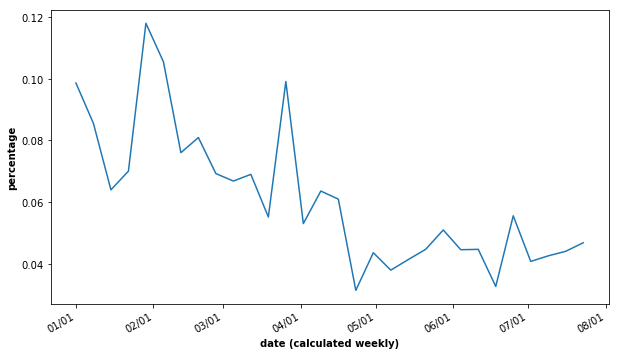

In [19]:
splitted_df = draw_graph(df, splitted=False)

/homes/jhpark/anaconda2/envs/tf/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


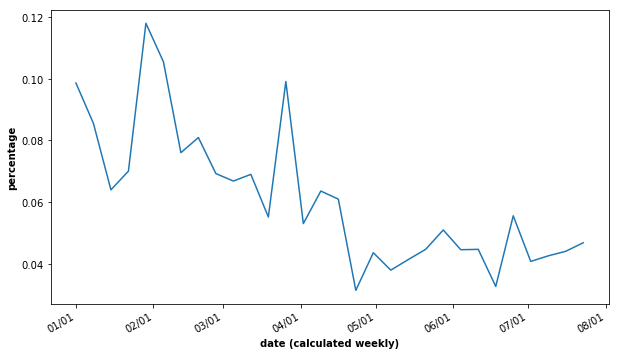

In [20]:
splitted_df = draw_graph(splitted_df, splitted=True)

In [24]:
total_count = 0
total_abusive = 0

for timeframe in splitted_df:
    total_abusive += timeframe["agree_count"]
    total_count += len(timeframe["df"])
total_abusive/total_count, total_abusive, total_count

(0.05011775477744583, 31857, 635643)

In [25]:
total_texts = []
total_gender = []
total_location = []

abusive_texts = []
abusive_gender = []
abusive_location = []

for timeframe in splitted_df:
    texts = timeframe["df"].text.tolist()
    gender = timeframe["df"].user_gender.tolist()
    location = timeframe["df"].location.tolist()
    assert len(texts) == len(gender) and len(gender) == len(location)
    assert len(timeframe["hybrid_preds"]) == len(texts)
    
    for i, pred in enumerate(timeframe["hybrid_preds"]):
        if timeframe["word_preds"][i] == pred and pred == 1:
            abusive_texts.append(texts[i])
            abusive_gender.append(gender[i])
            abusive_location.append(location[i])
            
    total_texts += texts
    total_gender += gender
    total_location +=  location

assert len(total_texts) == len(total_gender) and len(total_texts) == len(total_location)

In [26]:
random.sample(abusive_texts, 100)

["@PressSec @POTUS @theresa_may Keep kicking ass & taking taking names. Haven't had time to watch one Netflix movie since 20th. Love it!",
 '@DitsyAlexa @theresa_may oh shiiiit youre mad LUL',
 "@IrvineWelsh can I commission Jim for a mutilation of a bust of @theresa_may ? Only one stipulation- that it's the real one! #TheBladeArtist",
 'Can any1 explain why waspi r saying they donnot @theresa_may have our pensions? when some clearly do the higher 1 including Anne Keen?',
 '#GeneralElection2017 If @Theresa_May said "I will close down all mosques that preach hate", would @Conservatives...',
 'Is @theresa_may listening? Conventional approach cannot tame radical Islam. Before they completely take over British culture, do something!',
 '@EsylltMair @AndrewLeyshon She had to hold on to his hands to prevent the audacity of #grope #Trump #TrumpMay @theresa_may @POTUS #narcissus',
 '@theresa_may why would you want to work with a racist, ignorant, sexist, incompetent child??',
 "@theresa_may yo

#### total gender

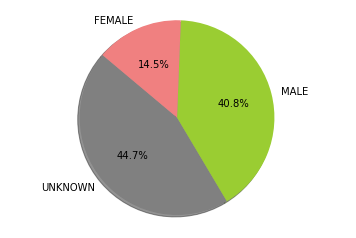

In [27]:
plt.pie([total_gender.count("UNKNOWN"), total_gender.count("MALE"), total_gender.count("FEMALE")] , 
        labels=["UNKNOWN", "MALE", "FEMALE"], colors=['grey', 'yellowgreen', 'lightcoral'],
        shadow=True, startangle=140, autopct='%1.1f%%')
 
plt.axis('equal')
plt.show()

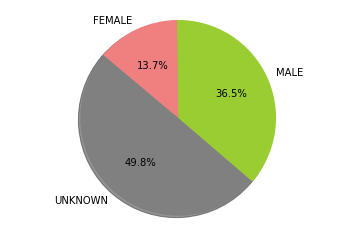

In [28]:
plt.pie([abusive_gender.count("UNKNOWN"), abusive_gender.count("MALE"), abusive_gender.count("FEMALE")] , 
        labels=["UNKNOWN", "MALE", "FEMALE"], colors=['grey', 'yellowgreen', 'lightcoral'],
        shadow=True, startangle=140, autopct='%1.1f%%')
 
plt.axis('equal')
plt.show()

In [29]:
from collections import Counter
total_location_counter= Counter(total_location)
abusive_location_counter= Counter(abusive_location)


In [ ]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    "Unknown": "UNKNOWN"
}

codes_key = {}
for key in us_state_abbrev:
    codes_key[us_state_abbrev[key]] = key

In [ ]:
for i, (state, count) in enumerate(total_location_counter.most_common(26)):
    if state != "None":
        print("%s: %s" % (i, codes_key[state]))

In [ ]:
for i, (state, count) in enumerate(abusive_location_counter.most_common(26)):
    if state != "None":
        print("%s: %s" % (i, codes_key[state]))
    

## co-occuring words

In [30]:
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
import string

In [31]:
stopWords = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)
tknzr = TweetTokenizer(reduce_len=True, preserve_case=False, strip_handles=False)

In [32]:
total_words = Counter()
true_words = Counter()

In [33]:
tknzr.tokenize("#hello world")

['#hello', 'world']

In [34]:
for tokens in [tknzr.tokenize(t.translate(translator)) for t in abusive_texts]:
    words = list(filter(lambda x: x not in stopWords, tokens))
    true_words.update(words)
for tokens in [tknzr.tokenize(t.translate(translator)) for t in total_texts]:
    total_words.update(list(filter(lambda x: x not in stopWords, tokens)))

In [35]:
len(total_words), len(true_words)

(221546, 38026)

In [36]:
remove = ["MD", "DT", "RP", "IN", "RB", "VB", "CD"]
blacklist = ["dont", "u", "didnt", "im", "right", "🇺", "🇸"]
_total_words = list(filter(lambda word: pos_tag([word[0]])[0][1] not in remove and word[0] not in blacklist, total_words.most_common(1000)))


In [37]:
for word, count in _total_words:
    print("%s %s" % (word, count))

theresamay 635792
brexit 56657
jeremycorbyn 48332
uk 40327
people 33645
ge2017 28818
conservatives 28223
us 26729
pm 25927
eu 25461
realdonaldtrump 25379
vote 20796
election 20174
think 19848
time 19243
country 18714
want 17982
good 17249
need 17044
please 16750
tory 16595
trump 15117
going 15116
potus 15102
strong 14319
cant 14102
skynews 13822
nhs 13779
deal 13489
tories 13476
shes 13241
number 13166
theresa 13162
says 13047
party 12749
stop 12651
labour 12291
debate 11510
youre 11493
bbcnews 11445
government 11235
£ 11131
british 11104
😂 10914
corbyn 10876
nicolasturgeon 10506
money 10456
said 10197
borisjohnson 10129
doesnt 10080
britain 9861
thats 9836
wont 9789
public 9592
today 9524
minister 9450
dup 9449
leader 9422
police 9355
way 9248
much 9161
great 9003
prime 8991
many 8933
stable 8926
got 8908
done 8829
resign 8736
support 8598
better 8462
hope 8251
new 8141
isnt 8138
voted 8093
needs 8034
job 7974
speech 7807
day 7742
nothing 7700
look 7640
pay 7628
help 7538
care 7502
be

In [38]:
remove = ["MD", "DT", "RP", "IN", "RB", "VB", "CD"]
_true_words = list(filter(lambda word: pos_tag([word[0]])[0][1] not in remove and word[0] not in blacklist, true_words.most_common(1000)))


In [39]:
for word, count in _true_words:
    print("%s %s" % (word, count))

theresamay 31856
jeremycorbyn 2444
realdonaldtrump 2346
uk 1873
eu 1866
islam 1720
muslims 1450
potus 1429
people 1362
muslim 1336
us 1291
country 1275
brexit 1122
want 998
skynews 998
stop 943
rights 941
think 927
trump 920
shes 840
conservatives 828
need 791
fucking 785
fuck 777
terrorists 750
number 739
youre 726
terrorism 716
cant 716
time 706
women 666
pm 640
tory 633
bbcnews 633
woman 631
vote 619
doesnt 609
muslimban 608
nigelfarage 602
british 597
terrorist 595
said 584
good 581
bitch 578
pussy 572
hate 566
going 565
please 564
ban 564
ass 561
cunt 556
wont 535
😂 535
islamic 533
nicolasturgeon 531
coward 530
human 529
gay 528
corbyn 504
child 500
shit 498
racist 498
borisjohnson 479
much 475
evil 473
tell 468
needs 459
thats 458
deport 452
britain 446
world 431
queen 422
nothing 418
theresa 409
man 408
face 407
says 406
got 405
way 403
many 401
peston 395
wants 385
bbcbreaking 379
isnt 376
children 368
look 354
stupid 354
countries 354
extremism 352
ask 350
religion 348
migrant

In [40]:
s = ""
for word, count in _total_words[:300]:
    for _ in range(int(count/100)):
        s += ("%s " % word)
s

'theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresama

In [41]:
s = ""
for word, count in _true_words[:300]:
    for _ in range(int(count/100)):
        s += ("%s " % word)
s

'theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresamay theresama

In [42]:
with open("may_stats.txt", "w") as f:
    for timeframe in splitted_df:
        s = "%s\t%s\t%s\n" % (timeframe["date"], timeframe["agree_count"], len(timeframe["df"]))
        f.write(s)
        print(s)

2017-01-01 00:00:00	593	7321

2017-01-08 00:00:00	1142	16145

2017-01-15 00:00:00	909	17999

2017-01-22 00:00:00	2047	35931

2017-01-29 00:00:00	5718	57902

2017-02-05 00:00:00	2205	24739

2017-02-12 00:00:00	782	12690

2017-02-19 00:00:00	416	6263

2017-02-26 00:00:00	454	8142

2017-03-05 00:00:00	658	12881

2017-03-12 00:00:00	652	11461

2017-03-19 00:00:00	848	20185

2017-03-26 00:00:00	1601	18474

2017-04-02 00:00:00	784	18697

2017-04-09 00:00:00	300	6037

2017-04-16 00:00:00	204	4395

2017-04-23 00:00:00	525	21586

2017-04-30 00:00:00	521	14468

2017-05-07 00:00:00	443	14619

2017-05-14 00:00:00	507	15025

2017-05-21 00:00:00	664	18711

2017-05-28 00:00:00	1214	28281

2017-06-04 00:00:00	2460	66685

2017-06-11 00:00:00	3065	82866

2017-06-18 00:00:00	934	35899

2017-06-25 00:00:00	732	15455

2017-07-02 00:00:00	607	18632

2017-07-09 00:00:00	329	9414

2017-07-16 00:00:00	309	8826

2017-07-23 00:00:00	234	5914

